## Read GGL outputs

NOTE: For blinded DVs or Y3

### **Y3 MagLim $\times$ Metacal**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import astropy.io.fits as fits

plt.rcParams.update({
    'font.family':'serif',
    'font.size':12.0,
    'axes.labelsize': 'x-large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    'axes.titlesize':'x-large',
    'legend.fontsize': 'large',
    'xtick.direction':'in',
    'ytick.direction':'in',
    'lines.linewidth':2,
    'patch.linewidth':2,
    'lines.color':'black',
    'mathtext.fontset' : 'stix',
    'figure.titlesize': 'xx-large',
    'figure.facecolor':  (1.0, 1.0, 1.0, 1.0),
    'axes.facecolor':    (1.0, 1.0, 1.0, 1.0), 
    'savefig.facecolor': (1.0, 1.0, 1.0, 1.0)})

colors = ['dodgerblue', 'darkgreen', 'darkorange', 'darkred', 'violet', 'slateblue']

In [2]:
# functions to read outputs for specific bins 

def read_ggl_outputs(dir_outputs, l_bins, s_bins, ang_nbins=20):
    
    ggl_file0 = f'{dir_outputs}/ggl_l{l_bins[0]}_s{s_bins[0]}.txt'
    with open(ggl_file0, 'r') as f:
        columns = f.readline().split()[1:]
    
    ggl_data = pd.DataFrame(columns=columns)
    
    l_zbin_col = []
    s_zbin_col = []
    
    for l_zbin in l_bins:
        for s_zbin in s_bins:
            
            l_zbin_col.append([l_zbin]*ang_nbins)
            s_zbin_col.append([s_zbin]*ang_nbins)
            
            ggl_file = f'{dir_outputs}/ggl_l{l_zbin}_s{s_zbin}.txt'
            ggl_data_bin = pd.DataFrame(np.genfromtxt(ggl_file, names=True))

            ggl_data = pd.concat([ggl_data, ggl_data_bin])
            
    ggl_data['l_zbin'] = np.concatenate(l_zbin_col)
    ggl_data['s_zbin'] = np.concatenate(s_zbin_col)
    
    return ggl_data.reset_index()

def read_cov(dir_outputs, l_bins, s_bins, cov_type='gammat', ang_nbins=20):
    
    cov_data = {}
    
    for l_zbin in l_bins:
        for s_zbin in s_bins:
            
            cov_file = f'{dir_outputs}/covariance/cov_l{l_zbin}_s{s_zbin}_{cov_type}.txt'
            cov = np.loadtxt(cov_file)
            cov_data[f'l{l_zbin}_s{s_zbin}'] = cov.T
            
    return cov_data

def get_err(cov, l_bins, s_bins):
    
    err = []
    
    for l_zbin in l_bins:
        for s_zbin in s_bins:
            err.append(np.sqrt(np.diag(cov[f'l{l_zbin}_s{s_zbin}'])))
            
    return np.array(np.concatenate(err))

In [3]:
dir_outputs = '/global/cfs/cdirs/des/elisa/y6_ggl/mcal/'

l_bins = [0,1,2,3,4,5]
s_bins = [0,1,2,3]

with open(dir_outputs+'2pt_NG_y6_maglim_mcal_UNBLINDED.pkl', 'rb') as f:
    ggl_data = pickle.load(f)

In [9]:
ggl_data.columns

Index(['theta', 'gammat_bf_rp', 'gammat', 'gammax_bf_rp', 'gammax',
       'gammat_rand', 'gammax_rand', 'boost', 'gammat_shot_noise', 'xi_npairs',
       'xi_npairs_rand', 'xi_weight', 'xi_weight_rand', 'l_zbin', 's_zbin',
       'err_gammat', 'err_gammax', 'err_rand', 'err_boost'],
      dtype='object')

In [6]:
# or for specific bins

dir_outputs = '/global/cfs/cdirs/des/elisa/y6_ggl/mcal/'

l_bins = [0,1,2,3,4,5]
s_bins = [0,1,2,3]
ang_nbins=20

ggl_data = read_ggl_outputs(dir_outputs, l_bins, s_bins, ang_nbins)

cov_gammat = read_cov(dir_outputs, l_bins, s_bins, 'gammat', ang_nbins)
ggl_data['err_gammat'] = get_err(cov_gammat, l_bins, s_bins)

cov_gammax = read_cov(dir_outputs, l_bins, s_bins, 'gammax', ang_nbins)
ggl_data['err_gammax'] = get_err(cov_gammax, l_bins, s_bins)

cov_boost = read_cov(dir_outputs, l_bins, s_bins, 'boost', ang_nbins)
ggl_data['err_boost'] = get_err(cov_boost, l_bins, s_bins)

cov_rand = read_cov(dir_outputs, l_bins, s_bins, 'rand', ang_nbins)
ggl_data['err_rand'] = get_err(cov_rand, l_bins, s_bins)

In [7]:
# or read theta, gammat_bf_rp with all corrections from 2pt file

dir_outputs = '/global/cfs/cdirs/des/elisa/y6_ggl/mcal/'
dv_file = dir_outputs+'2pt_NG_y6_maglim_mcal_UNBLINDED.fits'

with fits.open(dv_file) as dv:
    #print(dv[4].header)
    gammat = dv[4].data['VALUE']
    theta = dv[4].data['ANG']
    
# or using twopoint library
import twopoint as tp

gammat_y3 = tp.TwoPointFile.from_fits(dv_file).get_spectrum('gammat')
rowcols = np.max(gammat_y3.bin2)
pairs = gammat_y3.bin_pairs

theta = []
gammat = []
#err_gammat = []
for k, (i, j) in enumerate(pairs):
    theta.append(list(gammat_y3.get_pair(i, j)[0]))
    gammat.append(list(gammat_y3.get_pair(i, j)[1]))
    #err_gammat.append(list(gammat_y3.get_error(i, j)))
theta = np.concatenate(theta)
gammat = np.concatenate(gammat)
#err_gammat = np.concatenate(err_gammat)

### $\gamma_t (\theta)$

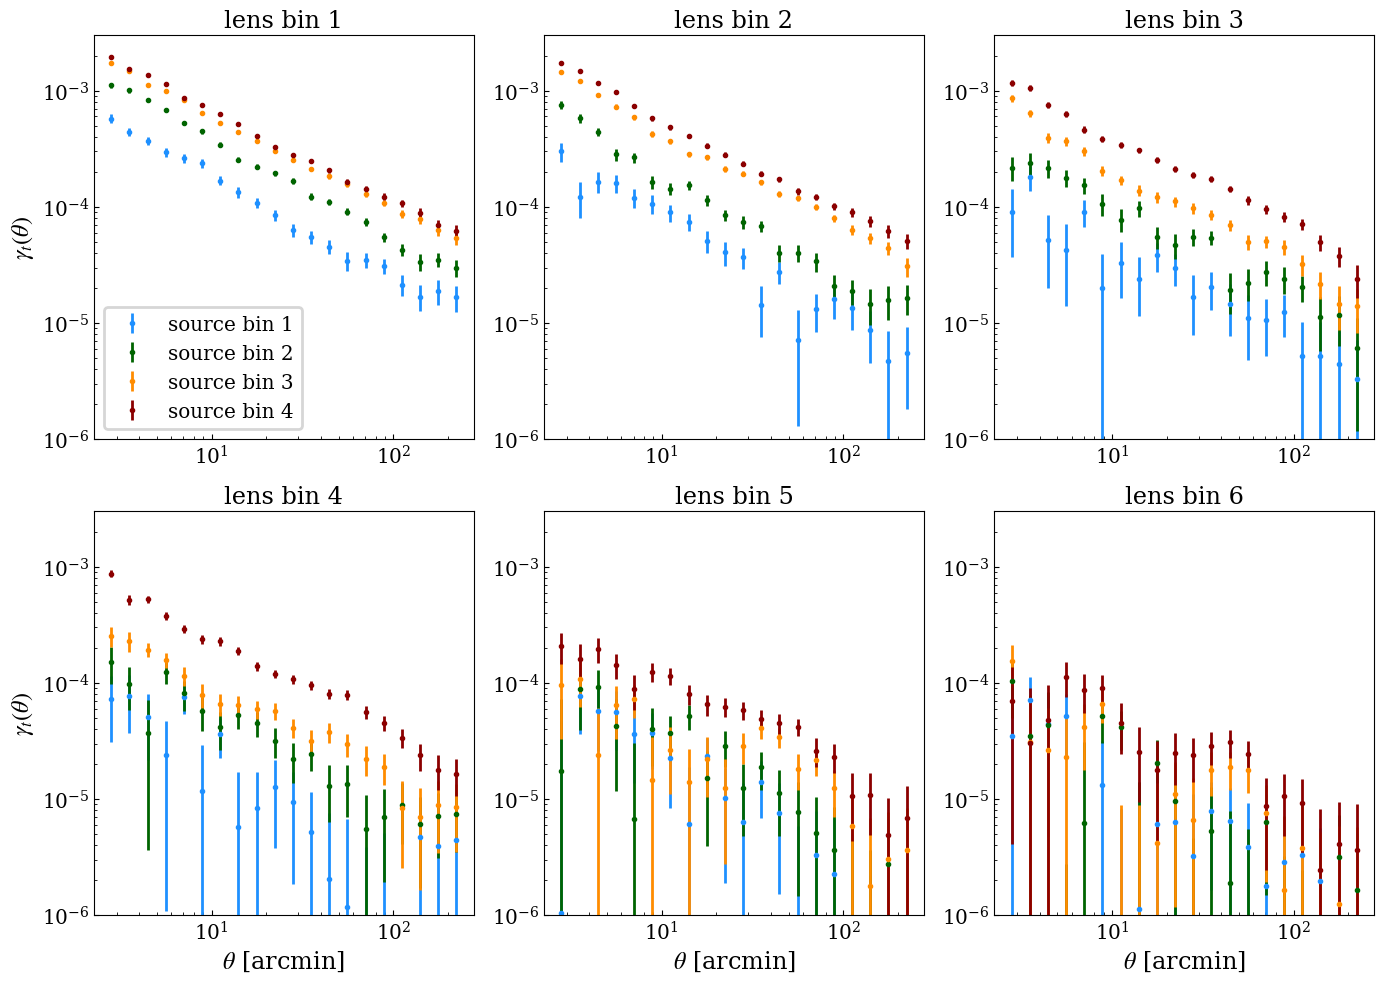

In [10]:
theta = ggl_data['theta']
gammat = ggl_data['gammat_bf_rp']
err_gammat = ggl_data['err_gammat']

fig = plt.figure(figsize=(14, 10))

for l,l_zbin in enumerate(np.unique(l_bins)):
    for s,s_zbin in enumerate(np.unique(s_bins)):
            
        i_min = 20*s + (len(np.unique(s_bins)))*20*l
        i_max = 20*s + (len(np.unique(s_bins)))*20*l + 20
        
        plt.subplot(2, 3, l+1)
        plt.errorbar(theta[i_min:i_max], gammat[i_min:i_max], err_gammat[i_min:i_max], 
                     ls='', marker='.', color=colors[s_zbin], label=f'source bin {s_zbin+1}')
            
    plt.title(f'lens bin {l_zbin+1}')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1e-6, 3e-3)
    if l in (3, 4, 5): plt.xlabel(r'$\theta$ [arcmin]')
    if l in (0, 3): plt.ylabel(r'$\gamma_t (\theta)$')
    if l==0: plt.legend()
    #plt.yticks([]) # add if Y6 blinded DV

plt.tight_layout()
fig.patch.set_alpha(1.0)
#plt.savefig('gammat.png', dpi=150, bbox_inches='tight')
plt.show()

### $\gamma_\times (\theta)$

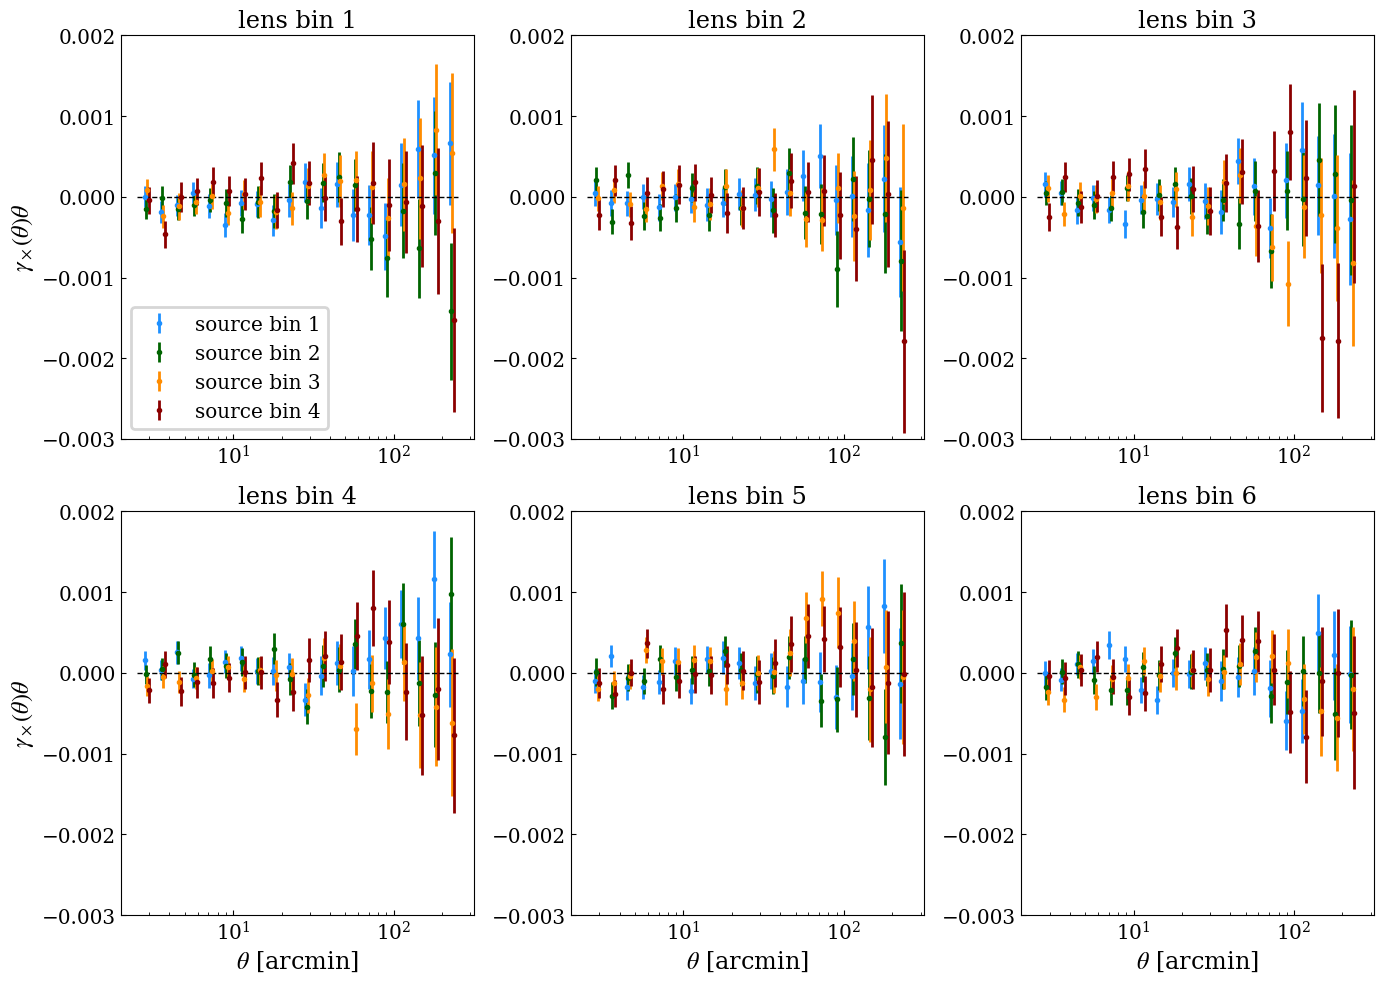

In [11]:
theta = ggl_data['theta']
gammax = ggl_data['gammax_bf_rp']
err_gammax = ggl_data['err_gammax']

fig = plt.figure(figsize=(14, 10))

for l,l_zbin in enumerate(np.unique(l_bins)):
    for s,s_zbin in enumerate(np.unique(s_bins)):
            
        i_min = 20*s + (len(np.unique(s_bins)))*20*l
        i_max = 20*s + (len(np.unique(s_bins)))*20*l + 20
        
        plt.subplot(2, 3, l+1)
        plt.errorbar(theta[i_min:i_max]+s*0.02*theta[i_min:i_max], gammax[i_min:i_max]*theta[i_min:i_max], err_gammax[i_min:i_max]*theta[i_min:i_max],
                     ls='', marker='.', color=colors[s_zbin], label=f'source bin {s_zbin+1}')
     
    plt.hlines(0, 2.5, 250, ls='--', lw=1)
    plt.title(f'lens bin {l_zbin+1}')
    plt.xscale('log')
    plt.ylim(-0.003, 0.002)
    if l in (3, 4, 5): plt.xlabel(r'$\theta$ [arcmin]')
    if l in (0, 3): plt.ylabel(r'$\gamma_\times (\theta) \theta$')
    if l==0: plt.legend()
    #plt.yticks([]) # add if Y6 blinded DV

plt.tight_layout()
fig.patch.set_alpha(1.0)
#plt.savefig('gammax.png', dpi=150, bbox_inches='tight')
plt.show()

### Boost factors

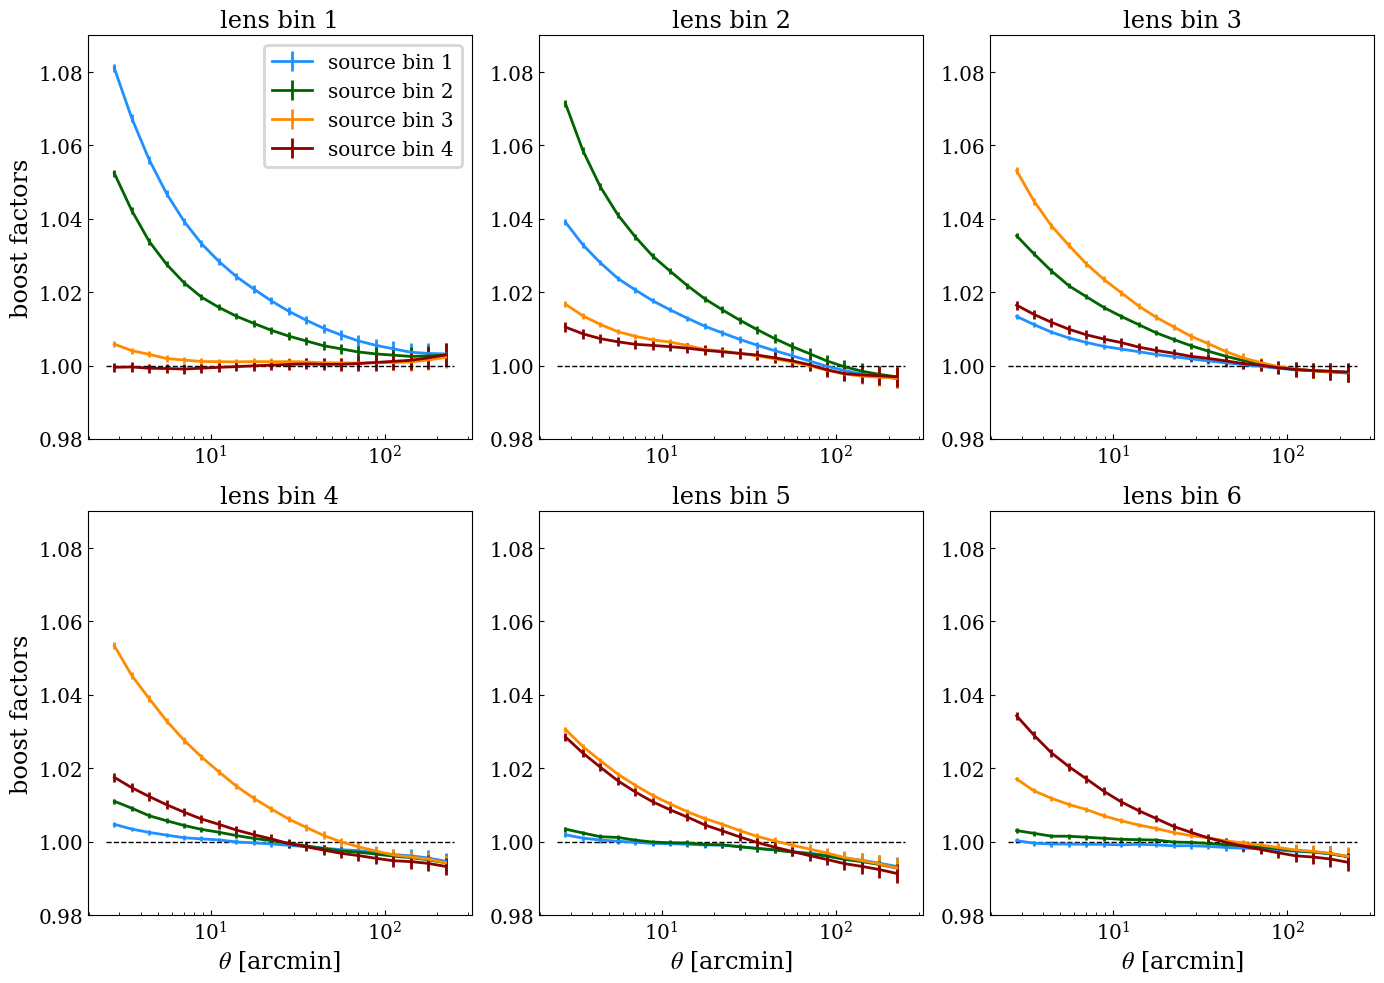

In [12]:
theta = ggl_data['theta']
boost = ggl_data['boost']
err_boost = ggl_data['err_boost']

fig = plt.figure(figsize=(14, 10))

for l,l_zbin in enumerate(np.unique(l_bins)):
    for s,s_zbin in enumerate(np.unique(s_bins)):
            
        i_min = 20*s + (len(np.unique(s_bins)))*20*l
        i_max = 20*s + (len(np.unique(s_bins)))*20*l + 20
        
        plt.subplot(2, 3, l+1)
        plt.errorbar(theta[i_min:i_max], boost[i_min:i_max], err_boost[i_min:i_max],
                     ls='-', marker='', color=colors[s_zbin], label=f'source bin {s_zbin+1}')
     
    plt.hlines(1, 2.5, 250, ls='--', lw=1)
    plt.title(f'lens bin {l_zbin+1}')
    plt.xscale('log')
    plt.ylim(0.98, 1.09)
    if l in (3, 4, 5): plt.xlabel(r'$\theta$ [arcmin]')
    if l in (0, 3): plt.ylabel('boost factors')
    if l==0: plt.legend()

plt.tight_layout()
fig.patch.set_alpha(1.0)
#plt.savefig('boost.png', dpi=150, bbox_inches='tight')
plt.show()

### $\gamma_t (\theta)$ w/o boost factors

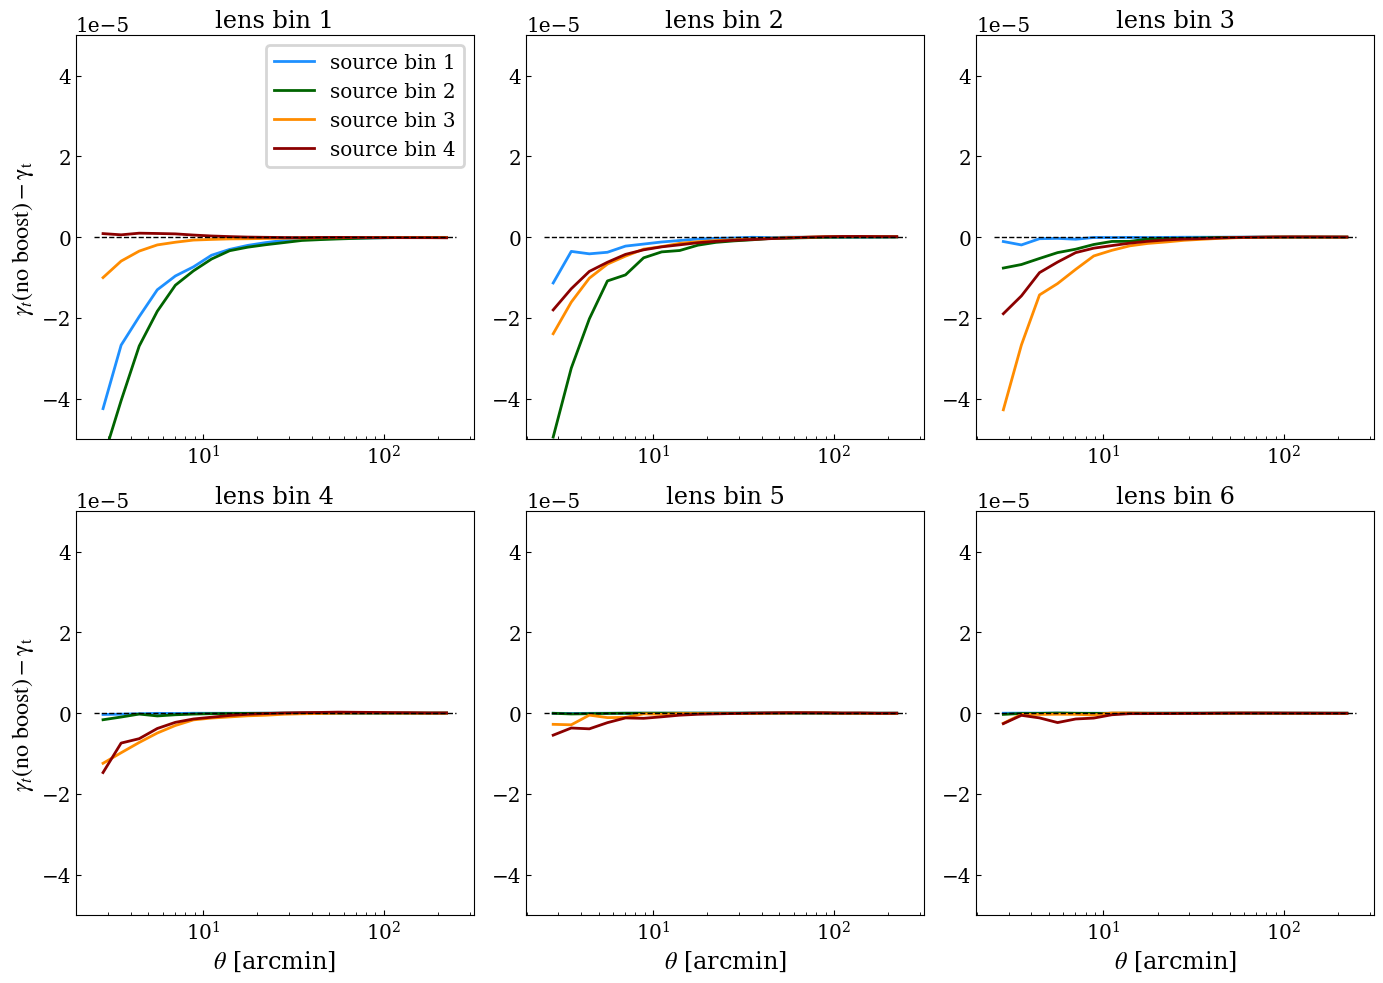

In [13]:
theta = ggl_data['theta']
gammat = ggl_data['gammat_bf_rp']
err_gammat = ggl_data['err_gammat']

# gammat_bf_rp = gammat*boost - gammat_rand
gammat_noboost = (ggl_data['gammat_bf_rp'] + ggl_data['gammat_rand'])/ggl_data['boost'] - ggl_data['gammat_rand']

fig = plt.figure(figsize=(14, 10))

for l,l_zbin in enumerate(np.unique(l_bins)):
    for s,s_zbin in enumerate(np.unique(s_bins)):
            
        i_min = 20*s + (len(np.unique(s_bins)))*20*l
        i_max = 20*s + (len(np.unique(s_bins)))*20*l + 20
        
        plt.subplot(2, 3, l+1)
        plt.plot(theta[i_min:i_max], gammat_noboost[i_min:i_max]-gammat[i_min:i_max],
                     ls='-', marker='', color=colors[s_zbin], label=f'source bin {s_zbin+1}')
     
    plt.hlines(0, 2.5, 250, ls='--', lw=1)
    plt.title(f'lens bin {l_zbin+1}')
    plt.xscale('log')
    plt.ylim(-5e-5, 5e-5)
    if l in (3, 4, 5): plt.xlabel(r'$\theta$ [arcmin]')
    if l in (0, 3): plt.ylabel(r'$\gamma_t \rm{(no~boost)} - \gamma_t$')
    if l==0: plt.legend()

plt.tight_layout()
fig.patch.set_alpha(1.0)
#plt.savefig('gammat_boost.png', dpi=150, bbox_inches='tight')
plt.show()

### $\gamma_t (\theta)$ around random points

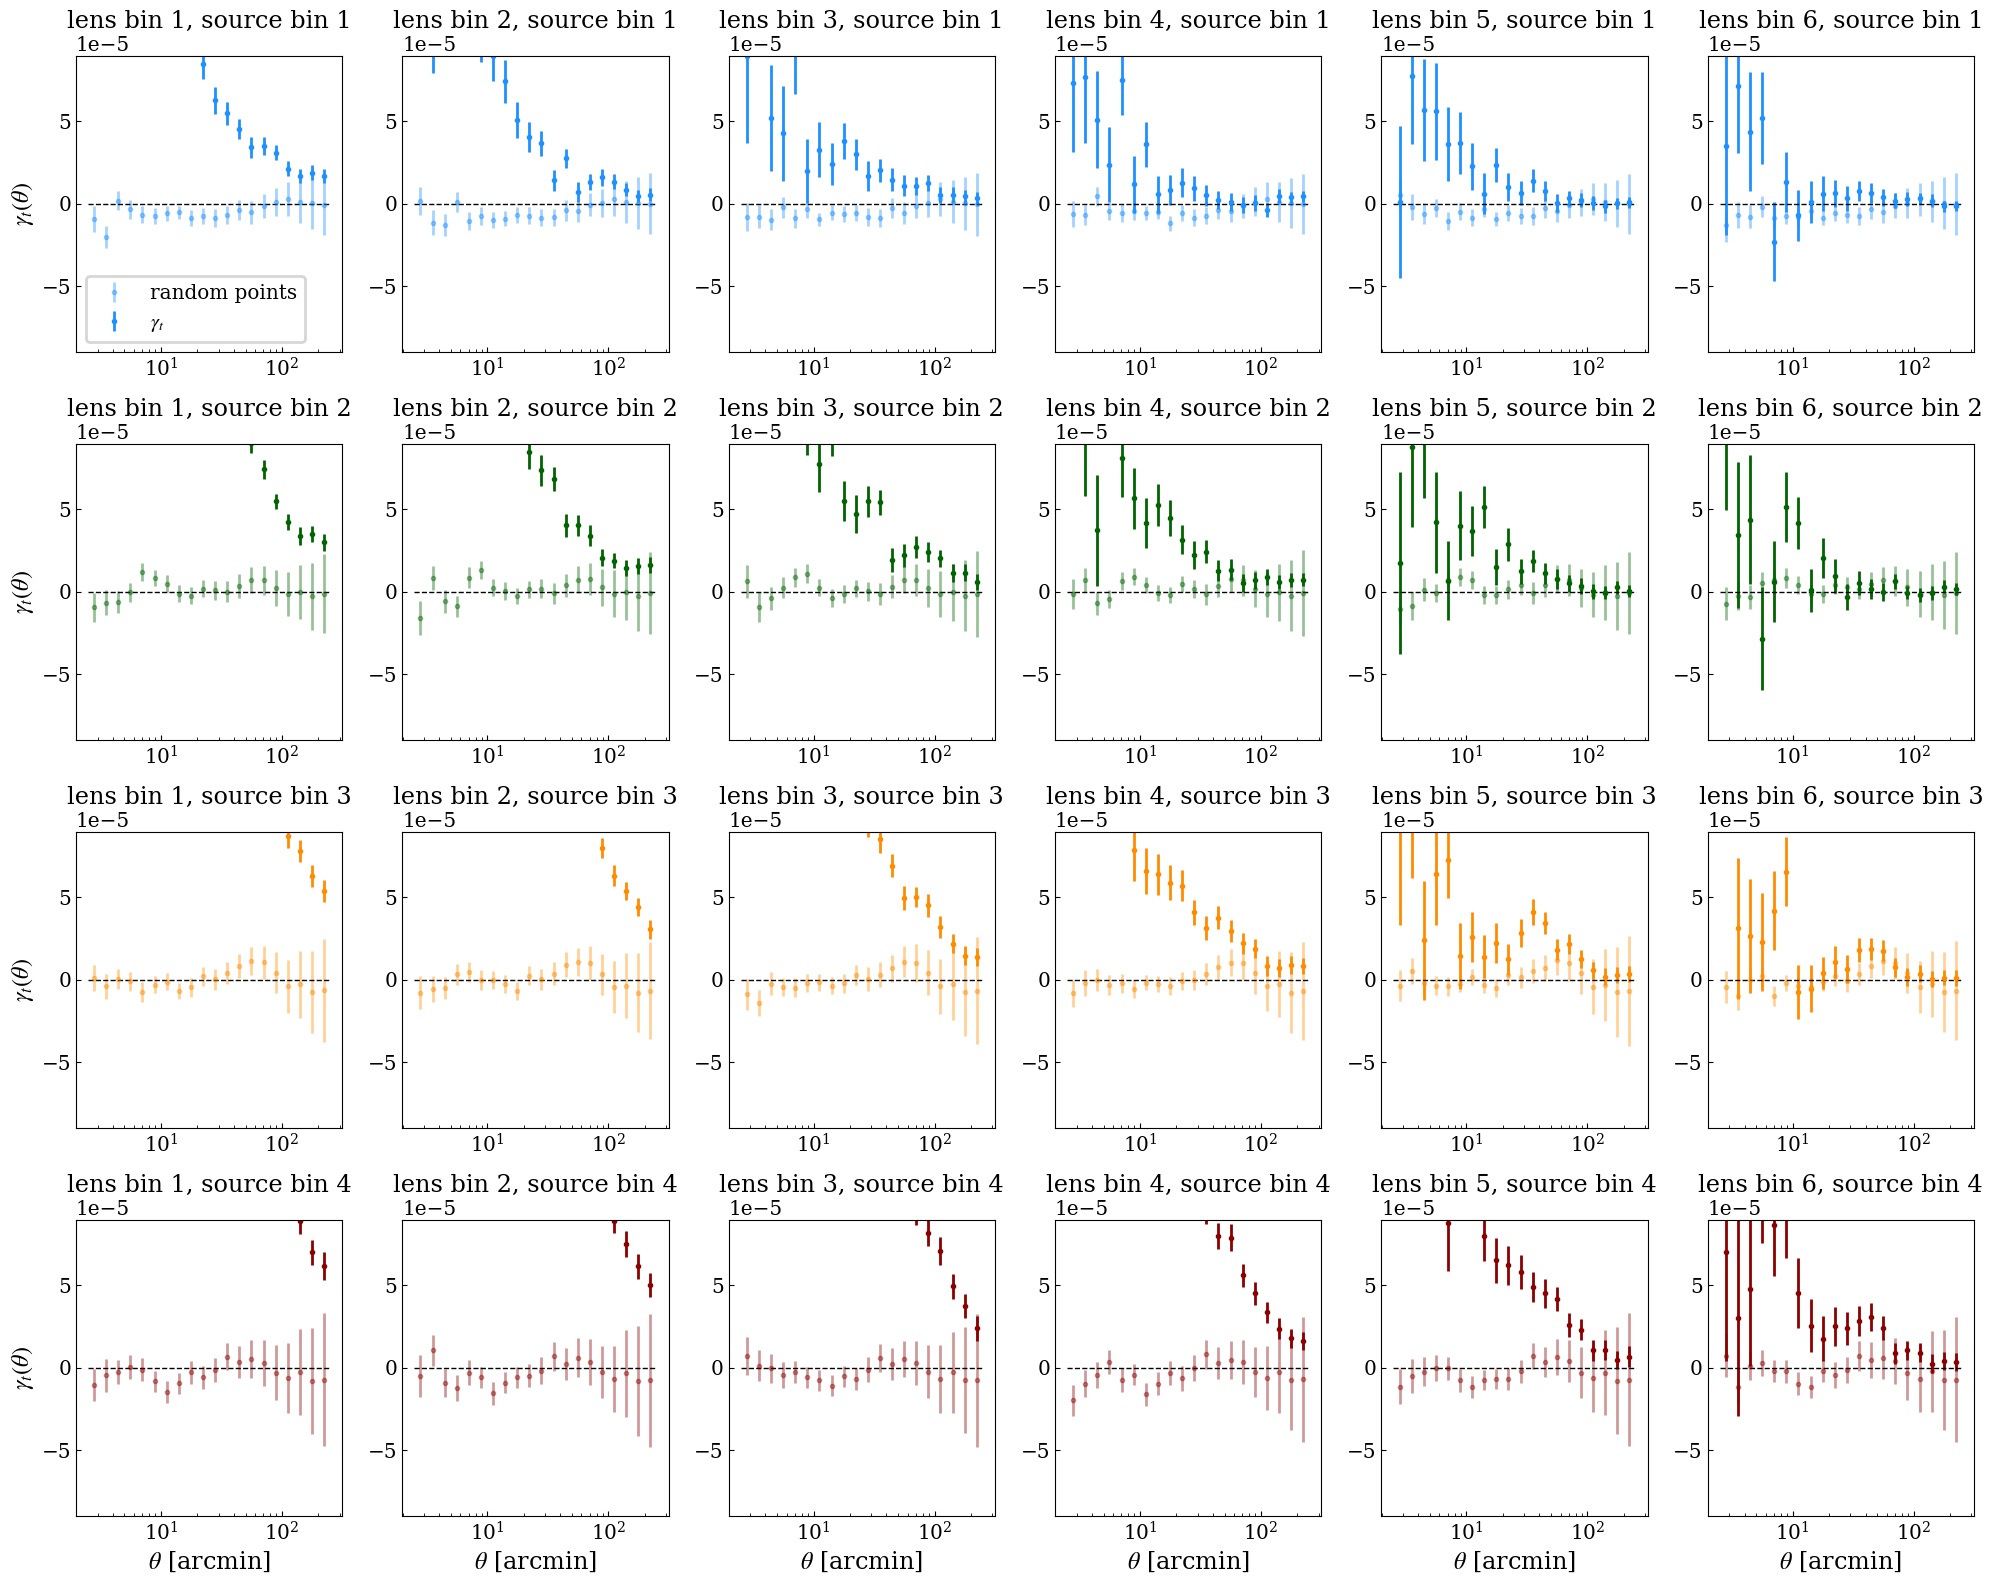

In [14]:
theta = ggl_data['theta']
gammat = ggl_data['gammat_bf_rp']
err_gammat = ggl_data['err_gammat']
gammat_rand = ggl_data['gammat_rand']
err_gammat_rand = ggl_data['err_rand']

fig = plt.figure(figsize=(20, 16))

for l,l_zbin in enumerate(np.unique(l_bins)):
    for s,s_zbin in enumerate(np.unique(s_bins)):
            
        i_min = 20*s + (len(np.unique(s_bins)))*20*l
        i_max = 20*s + (len(np.unique(s_bins)))*20*l + 20
        
        plt.subplot(4, 6, l+1+s*6)
        plt.errorbar(theta[i_min:i_max], gammat_rand[i_min:i_max], err_gammat_rand[i_min:i_max],
                     ls='', marker='.', color=colors[s_zbin], alpha=0.4, label=f'random points')
        plt.errorbar(theta[i_min:i_max], gammat[i_min:i_max], err_gammat[i_min:i_max],
                     ls='', marker='.', color=colors[s_zbin], label=r'$\gamma_t$')
        if s==0 and l==0: plt.legend()
     
        plt.hlines(0, 2.5, 250, ls='--', lw=1)
        plt.title(f'lens bin {l_zbin+1}, source bin {s_zbin+1}')
        plt.xscale('log')
        plt.ylim(-9e-5, 9e-5)
        
        if s==3: plt.xlabel(r'$\theta$ [arcmin]')
        if l==0: plt.ylabel(r'$\gamma_t (\theta)$')

plt.tight_layout()
fig.patch.set_alpha(1.0)
#plt.savefig('gammat_rand.png', dpi=150, bbox_inches='tight')
plt.show()

### **Y6 MagLim++ $\times$ BFD**

### $\gamma_t (\theta)$ w/o approximate method

In [3]:
l_bins = [0,1,2,3,4,5]
s_bins = [0,1,2,3]

dir_outputs = '/global/cfs/cdirs/des/elisa/y6_ggl/bfd/'
with open(dir_outputs+'2pt_NG_y6_maglim_bfd_UNBLINDED.pkl', 'rb') as f:
    ggl_data = pickle.load(f)
    
dir_outputs = '/global/cfs/cdirs/des/elisa/y6_ggl/bfd_approx/'
with open(dir_outputs+'2pt_NG_y6_maglim_bfd_approx_UNBLINDED.pkl', 'rb') as f:
    ggl_data_approx = pickle.load(f)

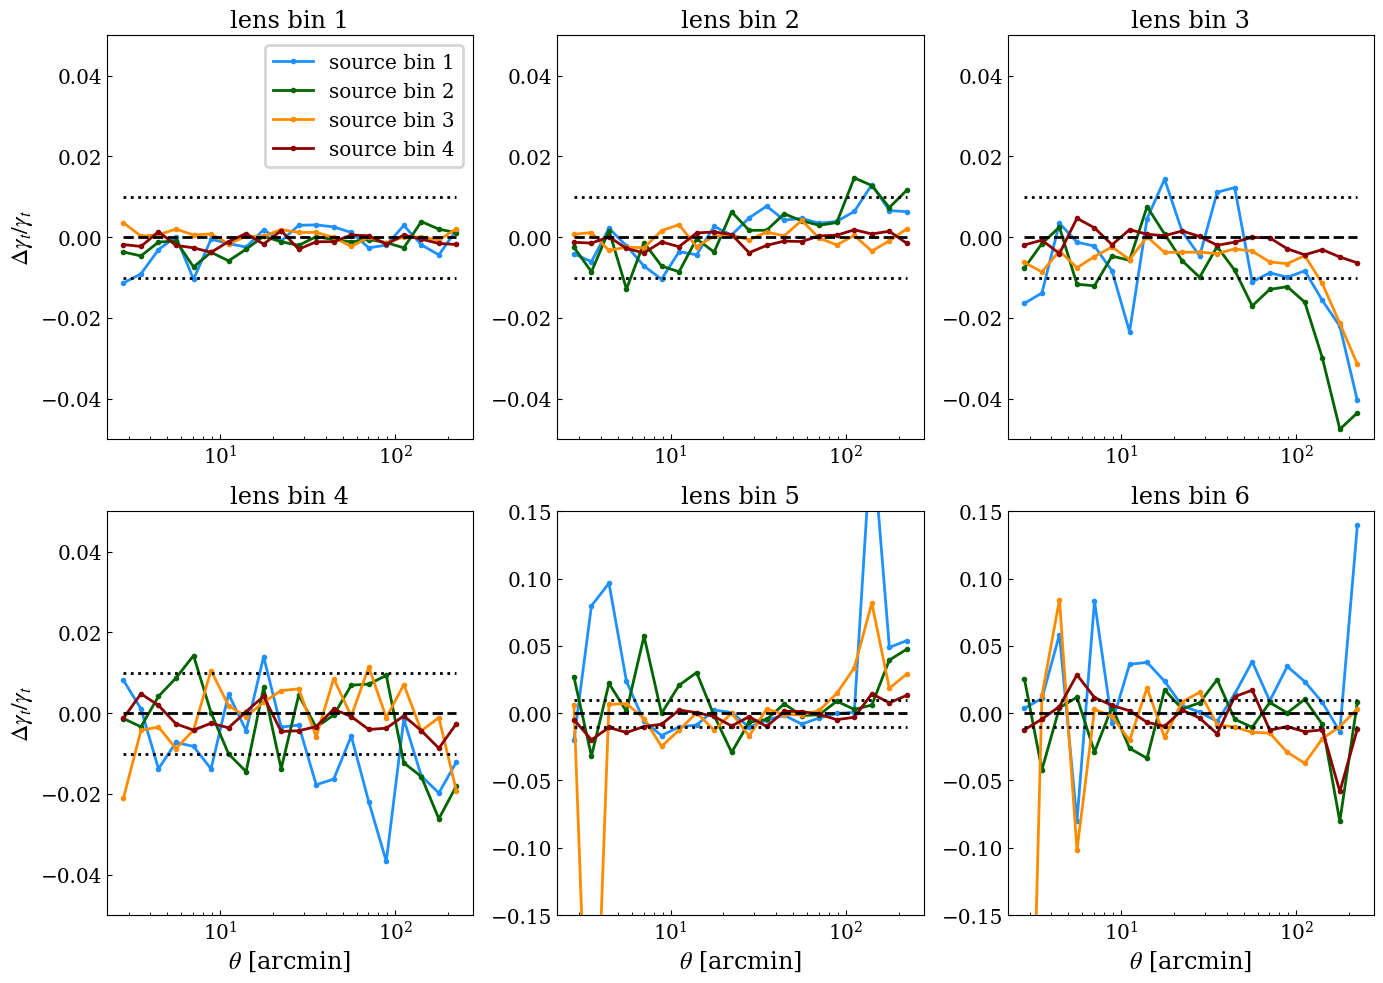

In [4]:
theta = ggl_data['theta']
gammat = ggl_data['gammat_bf_rp']
err_gammat = ggl_data['err_gammat']

theta_approx = ggl_data_approx['theta']
gammat_approx = ggl_data_approx['gammat_bf_rp']
err_gammat_approx = ggl_data_approx['err_gammat']

fig = plt.figure(figsize=(14, 10))

for l,l_zbin in enumerate(np.unique(l_bins)):
    for s,s_zbin in enumerate(np.unique(s_bins)):
            
        i_min = 20*s + (len(np.unique(s_bins)))*20*l
        i_max = 20*s + (len(np.unique(s_bins)))*20*l + 20
    
        plt.subplot(2, 3, l+1)
        plt.plot(theta[i_min:i_max], (gammat[i_min:i_max]-gammat_approx[i_min:i_max])/gammat_approx[i_min:i_max],
                    ls='-', marker='.', color=colors[s_zbin], label=f'source bin {s_zbin+1}')

    plt.hlines(0, np.min(theta), np.max(theta), ls='--')
    plt.hlines(0.01, np.min(theta), np.max(theta), ls=':')
    plt.hlines(-0.01, np.min(theta), np.max(theta), ls=':')

    if l<=3: plt.ylim(-0.05,0.05)
    if l>3: plt.ylim(-0.15,0.15)
    plt.title(f'lens bin {l_zbin+1}')
    #plt.yscale('log')
    plt.xscale('log')
    if l in (3, 4, 5): plt.xlabel(r'$\theta$ [arcmin]')
    if l in (0, 3): plt.ylabel(r'$\Delta \gamma_t/\gamma_t$')
    if l==0: plt.legend()

plt.tight_layout()
fig.patch.set_alpha(1.0)
#plt.savefig('gammat_bfd_approx.png', dpi=150, bbox_inches='tight')
plt.show()